# Feature Engineering

Building temporal, holiday, lag, route, and weather features for delay prediction. XGBoost uses 57 features, LSTM/TCN use 22. Route-level statistics are computed only on training data to prevent leakage.

In [1]:
# imports
import sys
import os
sys.path.append(os.path.abspath(".."))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.build_features import FeatureBuilder, build_features
from src.config import TRAIN_END

## Load Processed Data

In [2]:
# load processed daily route demand data
df = pd.read_csv('../data/processed/daily_route_demand.csv')
df['date'] = pd.to_datetime(df['date'])
print(f'Loaded {len(df):,} records')
df.head()

Loaded 47,460 records


,date,route,flight_count,cancelled_count,avg_dep_delay,avg_arr_delay,total_distance,carriers,cancel_rate,avg_daily_flights,...,apt2_severity,apt2_has_precipitation,apt2_has_snow,apt2_is_adverse,weather_severity_max,weather_severity_combined,has_adverse_weather,total_precip,total_snowfall,max_wind
0,2019-01-01,ATL-FLL,26,0,-0.423077,-6.615385,15106.0,"B6,DL,NK,WN",0.0,20.171513,...,2,1,0,0,3,2.5,1,13.2,0.00,25.3
1,2019-01-01,ATL-MCO,26,0,2.692308,-4.500000,10504.0,"B6,DL,F9,NK,WN",0.0,22.188369,...,2,0,0,0,3,2.5,1,12.9,0.00,18.2
2,2019-01-01,BOS-DCA,7,0,4.428571,7.714286,2793.0,"AA,B6",0.0,22.587863,...,2,1,0,0,3,2.5,1,11.8,0.00,37.9
3,2019-01-01,DCA-BOS,7,0,44.000000,35.142857,2793.0,"AA,B6",0.0,22.564265,...,3,1,0,1,3,2.5,1,11.8,0.00,37.9
4,2019-01-01,DEN-LAS,16,0,12.062500,-5.562500,10048.0,"F9,NK,UA,WN",0.0,20.278550,...,0,0,0,0,4,2.0,1,0.3,0.21,21.5


## Build Features

The `FeatureBuilder` class handles feature construction with built-in leakage prevention. Key design decisions:

- **train_end_date parameter**: Route-level statistics (`route_delay_mean`, `route_delay_std`) are computed only on data before this date, preventing information from validation/test periods leaking into features
- **Per-route lag computation**: Lags are computed separately per route to avoid cross-route contamination
- **Cyclical encodings**: Day of week and month use sine/cosine encoding for smooth periodicity (useful for gradient-based models)

In [3]:
# build all features using FeatureBuilder
builder = FeatureBuilder(df, train_end_date=TRAIN_END)
df_features = builder.build()

print(f'Output columns: {len(df_features.columns)}')
print(f'  XGBoost uses 57 of these, LSTM/TCN use 22')
print(f'  Extra columns: targets, dep_delay lags (unused), weather details')
print(f'\nDataset info:')
print(f'  Rows: {len(df_features):,}')
print(f'  Date range: {df_features["date"].min()} to {df_features["date"].max()}')
print(f'  train_end_date: {TRAIN_END}')
print(f'  Route stats computed from training data only')

  Adding weather features...
Output columns: 94
  XGBoost uses 57 of these, LSTM/TCN use 22
  Extra columns: targets, dep_delay lags (unused), weather details

Dataset info:
  Rows: 47,460
  Date range: 2019-01-01 00:00:00 to 2025-06-30 00:00:00
  train_end_date: 2024-01-01
  Route stats computed from training data only


## Lag Feature Correlation with Delay Target

Lag features capture the autoregressive nature of delays. The correlation matrix below shows how predictive each lag is:
- `lag_1` (yesterday's delay) has the highest correlation, as expected from the ACF analysis
- Longer lags still provide signal but with diminishing returns
- This validates building multiple lag horizons (1, 7, 14, 28 days)

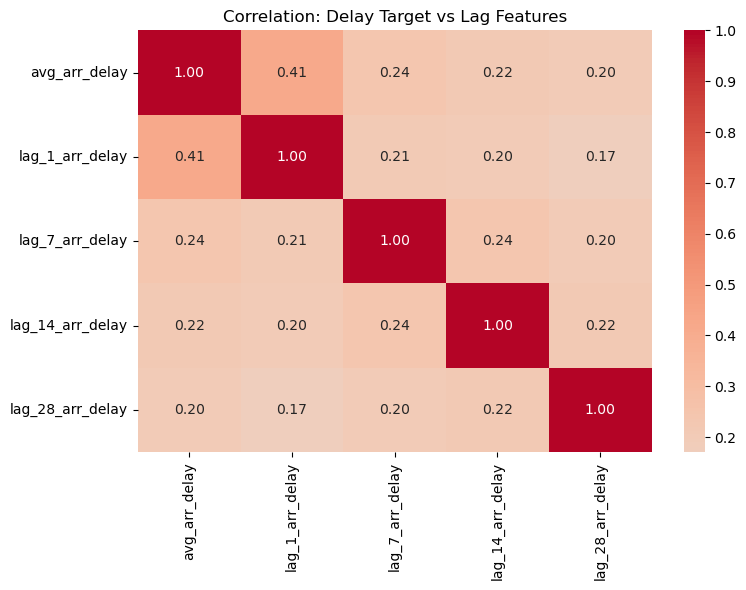

In [4]:
# correlation between delay target and lag features
lag_cols = ['avg_arr_delay', 'lag_1_arr_delay', 'lag_7_arr_delay', 'lag_14_arr_delay', 'lag_28_arr_delay']

corr_matrix = df_features[lag_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation: Delay Target vs Lag Features')
plt.tight_layout()
plt.show()

## Holiday Effects on Delays

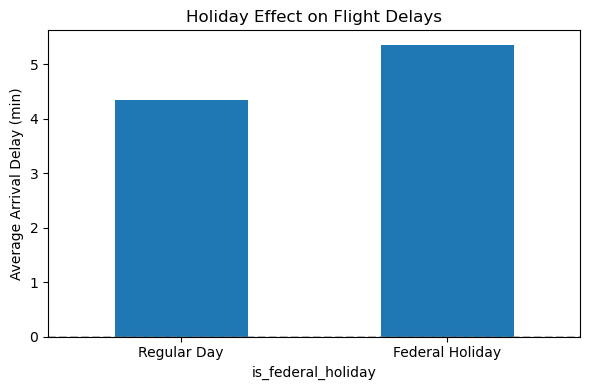

In [5]:
# compare delays on holidays vs regular days
holiday_effect = df_features.groupby('is_federal_holiday')['avg_arr_delay'].mean()

fig, ax = plt.subplots(figsize=(6, 4))
holiday_effect.plot(kind='bar', ax=ax)
ax.set_xticklabels(['Regular Day', 'Federal Holiday'], rotation=0)
ax.set_ylabel('Average Arrival Delay (min)')
ax.set_title('Holiday Effect on Flight Delays')
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## COVID Period Impact on Delays

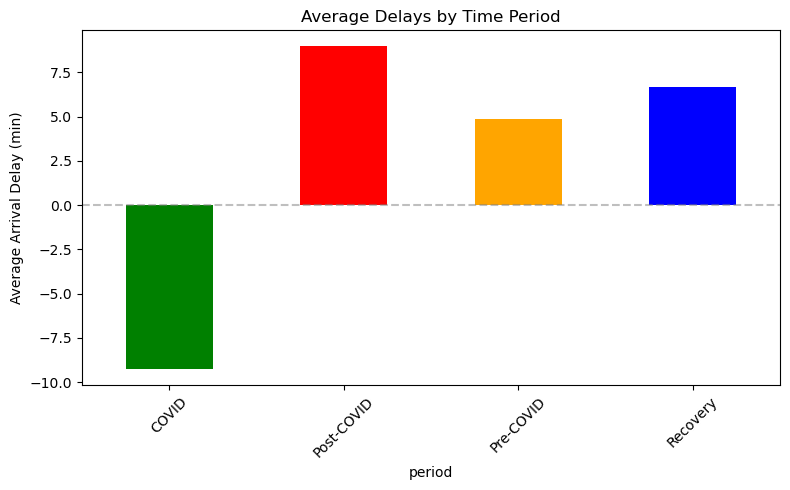

In [6]:
# compare delays across COVID time periods
viz_df = df_features.copy()
viz_df['period'] = 'Pre-COVID'
viz_df.loc[viz_df['is_covid_period'] == 1, 'period'] = 'COVID'
viz_df.loc[viz_df['is_covid_recovery'] == 1, 'period'] = 'Recovery'
viz_df.loc[viz_df['is_post_covid'] == 1, 'period'] = 'Post-COVID'

period_avg = viz_df.groupby('period')['avg_arr_delay'].mean()

fig, ax = plt.subplots(figsize=(8, 5))
period_avg.plot(kind='bar', ax=ax, color=['green', 'red', 'orange', 'blue'])
ax.set_ylabel('Average Arrival Delay (min)')
ax.set_title('Average Delays by Time Period')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Save Features

In [7]:
# save features to csv
output_path = '../data/processed/features.csv'
df_features.to_csv(output_path, index=False)
print(f'Saved features to {output_path}')
print(f'  Rows: {len(df_features):,}')
print(f'  Columns: {len(df_features.columns)}')
print(f'  Route-level stats computed with train_end_date={TRAIN_END}')

Saved features to ../data/processed/features.csv
  Rows: 47,460
  Columns: 94
  Route-level stats computed with train_end_date=2024-01-01


## Summary

### Model Feature Sets

Different models use different feature subsets:

| Model | Features | Rationale |
|-------|----------|-----------|
| **XGBoost** | 57 | Needs explicit lag columns since trees can't infer temporal patterns |
| **LSTM/TCN** | 22 | See target history in sequence, so lag columns are redundant |

The feature lists are defined in `src/config/features.py`.

### Feature Categories (XGBoost's 57)

| Category | Count | Examples |
|----------|-------|----------|
| Calendar/Holiday | 17 | day_of_week, month, is_weekend, is_federal_holiday, days_to_holiday |
| COVID | 3 | is_covid_period, is_covid_recovery, is_post_covid |
| Lag/Rolling | 9 | lag_1/7/14/28, rolling_mean_7/14, rolling_std_7/14, ewm_7 |
| Route | 6 | route_encoded, route_mean_demand, route_delay_mean |
| Weather | 22 | severity, precip, snowfall, temp, wind at both airports |
| **Total** | **57** | |

### Data Leakage Prevention

Route-level statistics are computed with `train_end_date=2024-01-01`. This ensures validation and test sets never see information computed from their own time periods.

**Next:** [03_baseline_models.ipynb](03_baseline_models.ipynb) 